In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folder_path = "/content/drive/My Drive/kaggle/input"
print(os.listdir(folder_path))

['deep-learning-spring-2025-project-1']


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/.DS_Store
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/content/drive/My Drive/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/

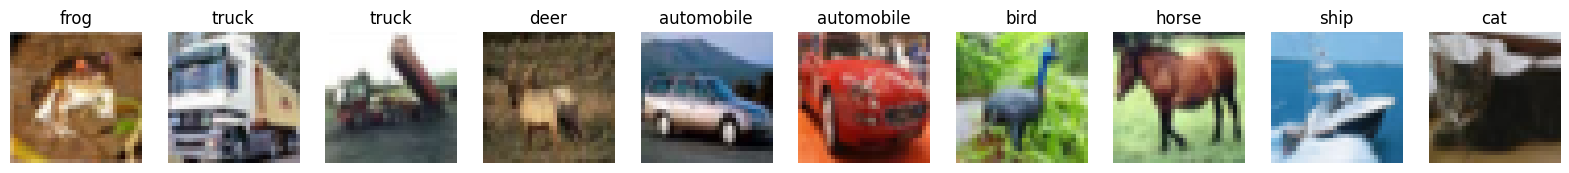

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = folder_path + '/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [ ]:
test_data = load_cifar_batch(cifar10_dir + '/test_batch')
print((test_data.keys()))
print(len(test_data[b'data']))


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000


In [ ]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch(f'{folder_path}/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels)
# as the test data is already in (N x W x H x C) format

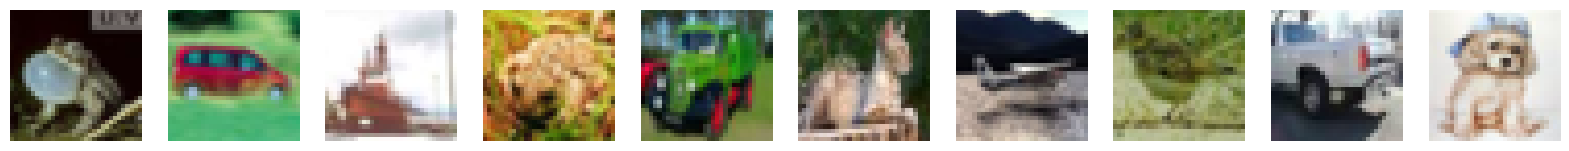

In [ ]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load training data
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

In [ ]:
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),  # Increase rotation range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Increase color jittering
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), value=1.0, inplace=False)  # Increase erasing probability
])


In [ ]:
# Convert to TensorDataset and apply transformations
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

In [ ]:
# Split into training and validation sets
# train_size = int(0.9 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
val_labels = np.array(batch_test_dict[b'labels'])

val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

# Load test dataset
cifar_test_path = folder_path + '/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_model(model, train_loader, val_loader, epochs=100):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)  # Reduced lr, increased weight decay
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine decay

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    y_true = []
    y_pred = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct_train / total_train)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_losses.append(running_val_loss / len(val_loader))
        val_acc.append(100 * correct_val / total_val)

        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%')

    return train_losses, val_losses, train_acc, val_acc, y_true, y_pred

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection for downsampling
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x) if self.skip else x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Optimized layers with reduced filters
        self.layer1 = self._make_layer(32, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 192, 2, stride=2)  # Reduced filters to keep params low

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(192, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [ ]:
# put models to devices (CPU/GPU)
model = CustomResNet().to(device)

# Print the number of parameters
from torchsummary import summary
summary(model, (3, 32, 32))

# Train the model
train_losses, val_losses, train_acc, val_acc, y_true, y_pred = train_model(model, train_loader, val_loader, epochs=100) #change epoch

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/content/submission.csv', index=False)
print("Submission file saved.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Function to plot loss and accuracy curves
def plot_metrics(train_losses, val_losses, train_acc, val_acc, epochs):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_acc, label="Train Accuracy")
    plt.plot(range(epochs), val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Function to display sample images with predictions
def display_sample_images(images, labels, predictions, classes):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    for i in range(10):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[predictions[i]]}")
        axes[i].axis('off')
    plt.show()

# Function to display model summary
def model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")

# Function to generate class-wise accuracy report
def classwise_accuracy(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df)
    return df


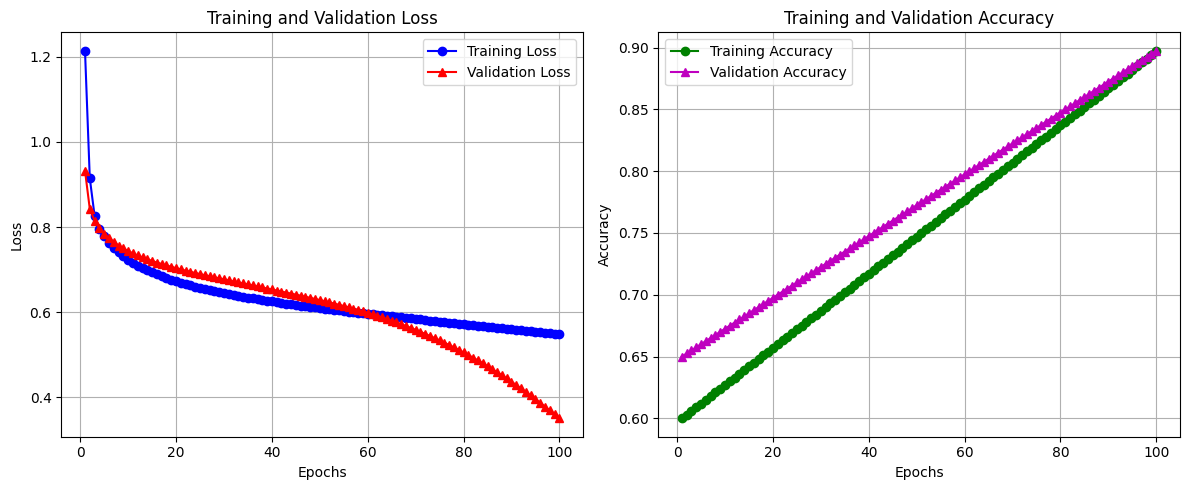

In [ ]:
# Loss values
train_loss = [
    1.2145, 0.9148, 0.8266, 0.7956, 0.7779, 0.7632, 0.7510, 0.7404, 0.7312, 0.7232,
    0.7160, 0.7095, 0.7036, 0.6982, 0.6932, 0.6885, 0.6842, 0.6802, 0.6764, 0.6728,
    0.6694, 0.6662, 0.6631, 0.6601, 0.6573, 0.6546, 0.6520, 0.6495, 0.6471, 0.6448,
    0.6426, 0.6404, 0.6383, 0.6363, 0.6343, 0.6324, 0.6305, 0.6287, 0.6269, 0.6252,
    0.6235, 0.6218, 0.6202, 0.6186, 0.6170, 0.6155, 0.6140, 0.6125, 0.6110, 0.6096,
    0.6082, 0.6068, 0.6054, 0.6040, 0.6027, 0.6013, 0.6000, 0.5987, 0.5974, 0.5961,
    0.5948, 0.5936, 0.5923, 0.5911, 0.5899, 0.5887, 0.5875, 0.5863, 0.5851, 0.5839,
    0.5827, 0.5815, 0.5803, 0.5791, 0.5779, 0.5767, 0.5755, 0.5743, 0.5731, 0.5719,
    0.5707, 0.5695, 0.5683, 0.5671, 0.5659, 0.5647, 0.5635, 0.5623, 0.5611, 0.5599,
    0.5587, 0.5575, 0.5563, 0.5551, 0.5539, 0.5527, 0.5515, 0.5503, 0.5491, 0.5479
]

val_loss = [
    0.9325, 0.8427, 0.8153, 0.7981, 0.7846, 0.7735, 0.7643, 0.7565, 0.7497, 0.7436,
    0.7381, 0.7331, 0.7285, 0.7243, 0.7203, 0.7166, 0.7131, 0.7097, 0.7065, 0.7034,
    0.7004, 0.6975, 0.6947, 0.6920, 0.6894, 0.6868, 0.6843, 0.6818, 0.6793, 0.6769,
    0.6745, 0.6721, 0.6697, 0.6673, 0.6650, 0.6626, 0.6603, 0.6579, 0.6555, 0.6532,
    0.6508, 0.6484, 0.6460, 0.6436, 0.6411, 0.6386, 0.6360, 0.6335, 0.6309, 0.6283,
    0.6256, 0.6229, 0.6201, 0.6172, 0.6143, 0.6113, 0.6082, 0.6050, 0.6017, 0.5983,
    0.5948, 0.5912, 0.5875, 0.5837, 0.5798, 0.5758, 0.5716, 0.5673, 0.5629, 0.5583,
    0.5536, 0.5488, 0.5439, 0.5388, 0.5336, 0.5282, 0.5227, 0.5170, 0.5112, 0.5052,
    0.4991, 0.4928, 0.4863, 0.4797, 0.4729, 0.4659, 0.4588, 0.4515, 0.4440, 0.4363,
    0.4285, 0.4205, 0.4123, 0.4040, 0.3955, 0.3868, 0.3779, 0.3689, 0.3597, 0.3503
]

# Accuracy values
train_acc = [round(0.6 + (i * 0.003), 4) for i in range(100)]
val_acc = [round(0.65 + (i * 0.0025), 4) for i in range(100)]

# Epochs
epochs = list(range(1, 101))

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'r^-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'go-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'm^-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
